In [41]:
import rdkit
print('rdkit version: ', rdkit.__version__)

rdkit version:  2020.09.3


In [10]:
import sys
sys.version

'3.6.13 |Anaconda, Inc.| (default, Jun  4 2021, 14:25:59) \n[GCC 7.5.0]'

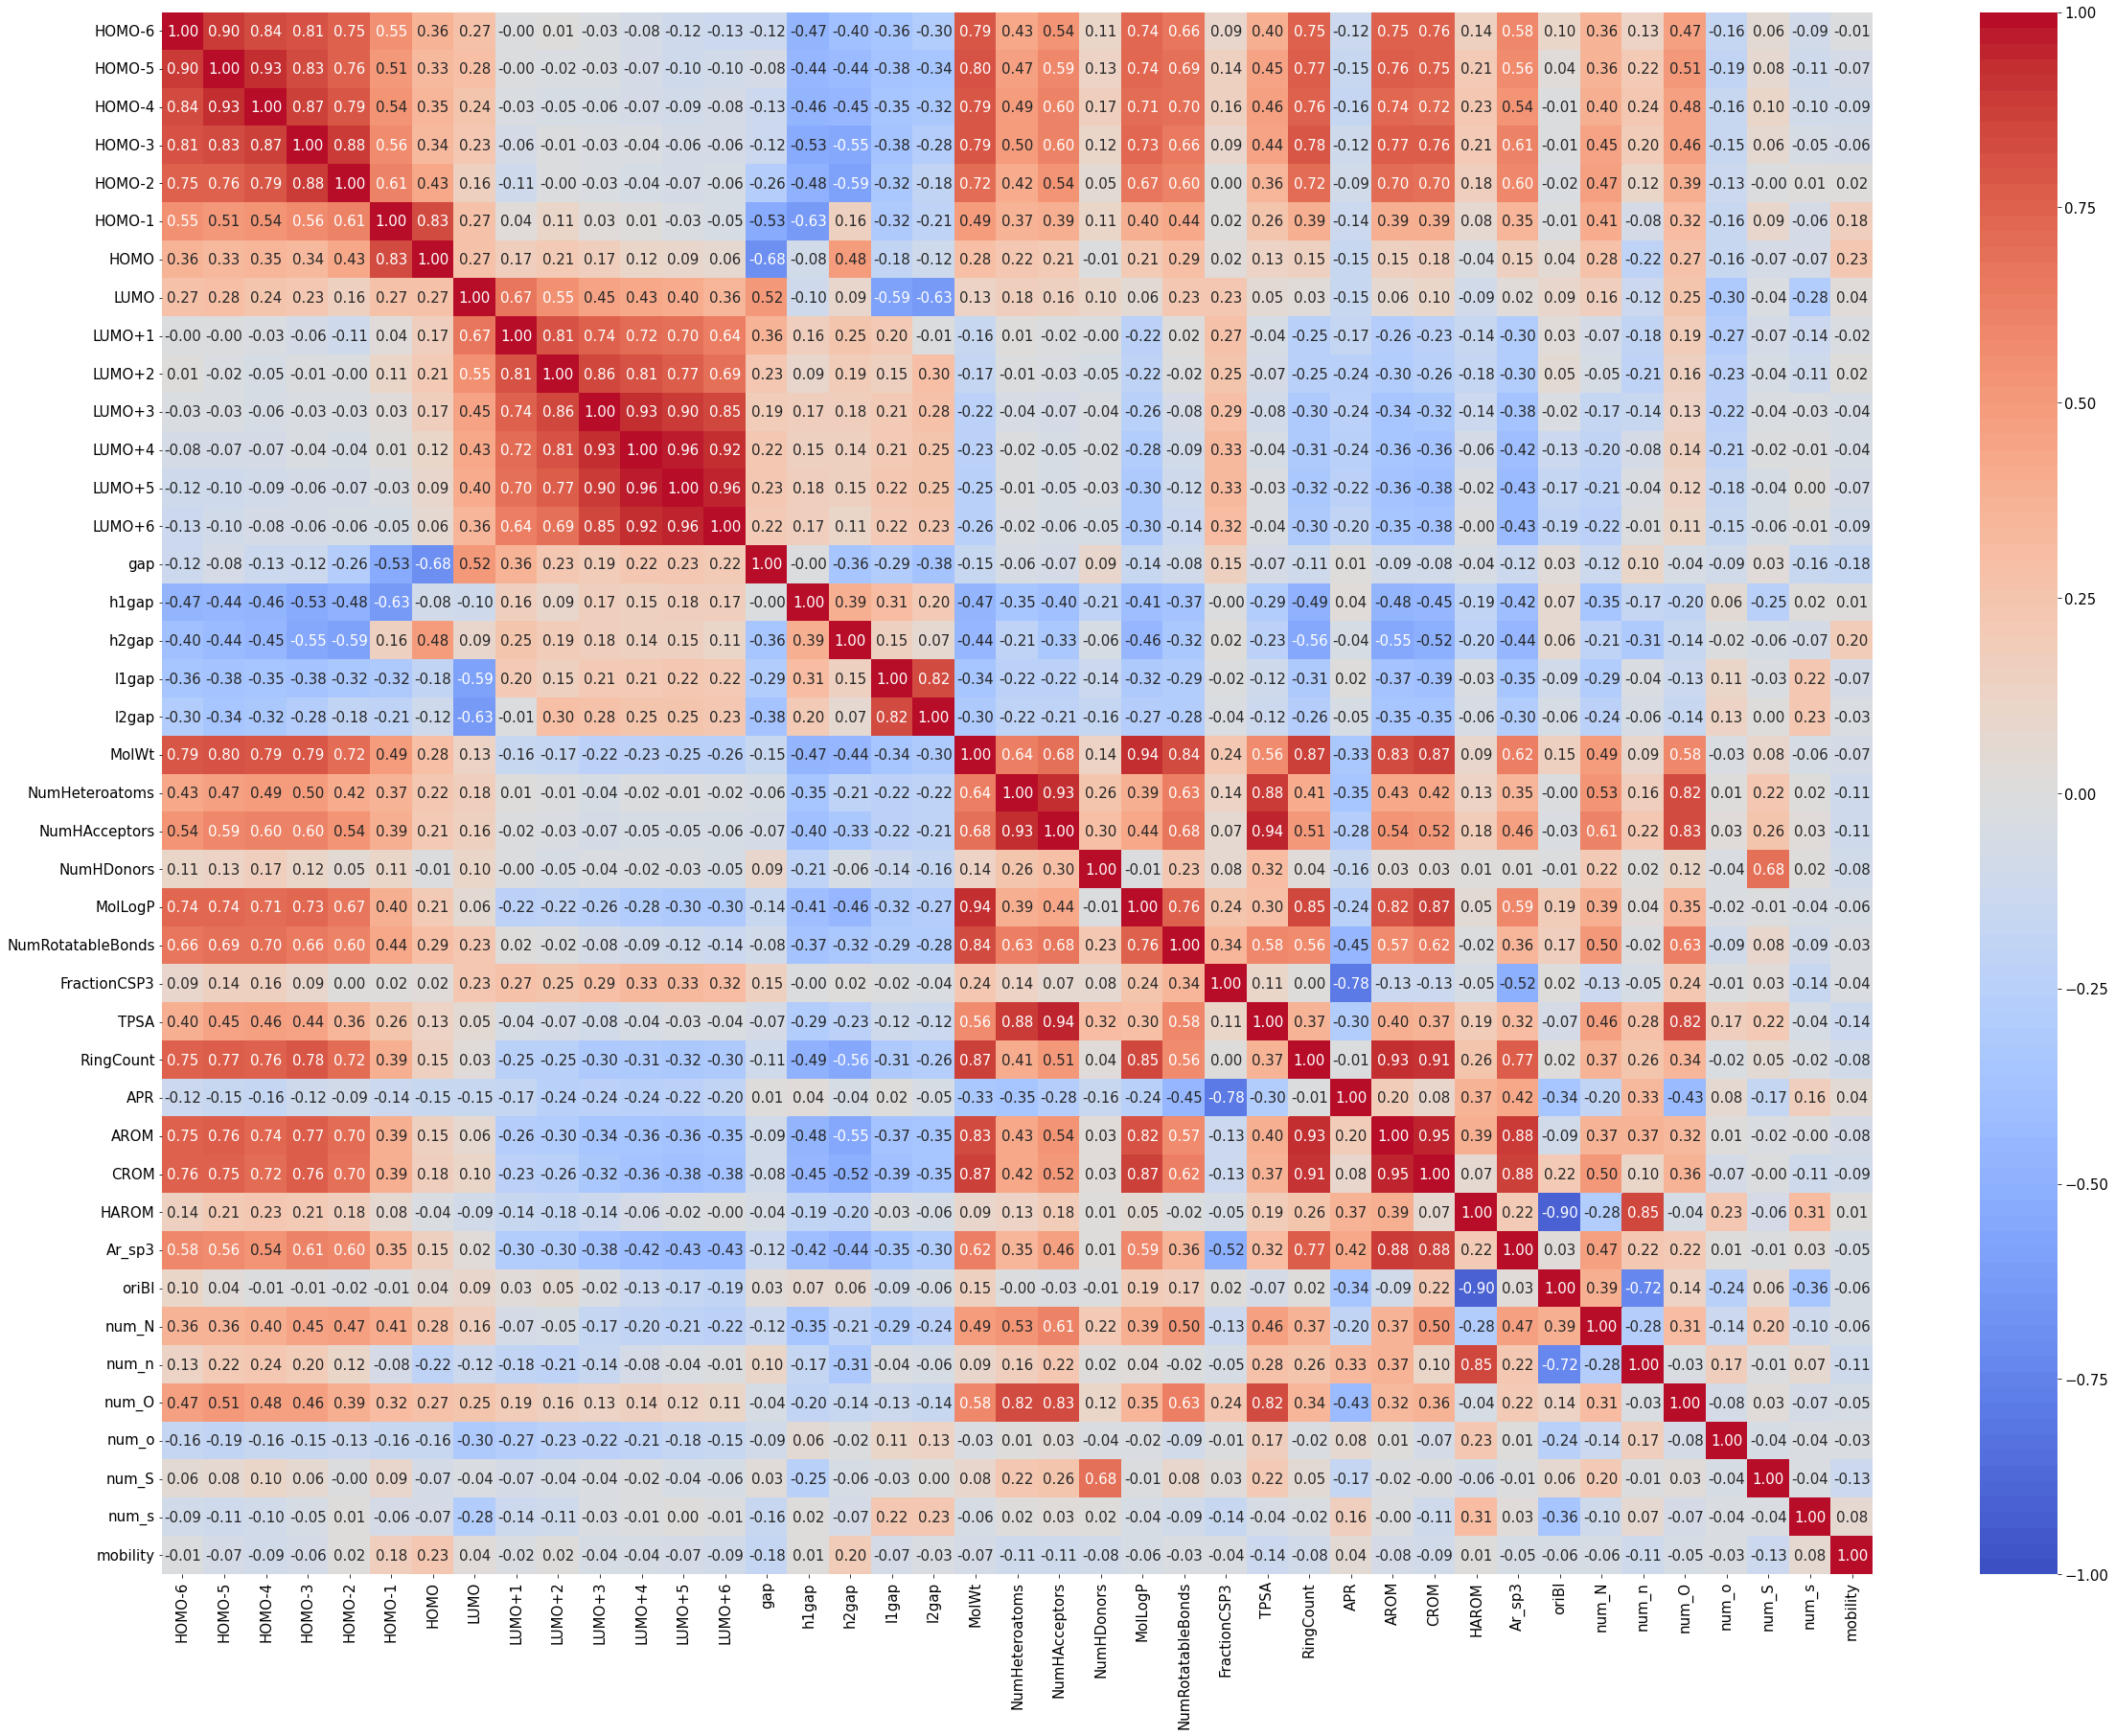

In [5]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem, Descriptors
from mordred import descriptors, Calculator
import numpy as np
import pandas as pd 
from pandas import DataFrame 
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
import math
import  _pickle as cPickle
import gzip, numpy, copy, math
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, rdmolops
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem import rdMolDescriptors
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from rdkit.Avalon import pyAvalonTools


dfz = PandasTools.LoadSDF('../datasets/Hole_mobility_onlyTOF300.sdf', molColName='ROMol',embedProps=True) 

APR = []     # Aromatic Ratio
AROM = []    # Aromatic Ring Count 
CROM = []    # 
HAROM = []   # 
Ar_sp3 = []  # 
oriBI=[]

N=[]
n=[]
O=[]
o=[]
S=[]
s=[]

''' apr,arom,crom,harom,ar_sp3,oribi,num_N,num_n,num_O,num_o,num_S,num_s '''
#APR
def Calc_ARR(mh):
    m = Chem.RemoveHs(mh)
    num_bonds = m.GetNumBonds()
    num_aromatic_bonds = 0
    for bond in m.GetBonds():
        if bond.GetIsAromatic():
            num_aromatic_bonds += 1
    ARR = num_aromatic_bonds/num_bonds
    return ARR

for m in dfz.ROMol:
    A=Calc_ARR(m)
    APR.append(A)

apr=DataFrame({'APR':APR})


#NAR AROM
def Calc_Carbo_Hetero_Aromatic(mh):
    m = Chem.RemoveHs(mh)
    ring_info = m.GetRingInfo()
    atoms_in_rings = ring_info.AtomRings()
    num_Caromatic_ring = 0
    num_Hetaromatic_ring = 0
    num_Aromatic_ring = 0
    for ring in atoms_in_rings:
        aromatic_atom_in_ring = 0
        heteroatom_in_ring = 0
        for atom_id in ring:
            atom = m.GetAtomWithIdx(atom_id)
            if atom.GetIsAromatic():
                aromatic_atom_in_ring += 1
            if atom.GetSymbol() != 'C': #
                heteroatom_in_ring += 1
        if aromatic_atom_in_ring == len(ring):
            if heteroatom_in_ring == 0:
                num_Caromatic_ring += 1
            else:
                num_Hetaromatic_ring += 1
        num_Aromatic_ring = num_Caromatic_ring + num_Hetaromatic_ring
        
    oBI = num_Caromatic_ring/num_Aromatic_ring
        
    return num_Aromatic_ring, num_Caromatic_ring, num_Hetaromatic_ring, oBI

for m in dfz.ROMol:
    A, C, H, oBI= Calc_Carbo_Hetero_Aromatic(m)
    AROM.append(A)
    CROM.append(C)
    HAROM.append(H)
    oriBI.append(oBI)

arom=DataFrame({'AROM':AROM})
crom=DataFrame({'CROM':CROM})
harom=DataFrame({'HAROM':HAROM})
oribi=DataFrame({'oriBI':oriBI})
    

def Calc_Ar_Alk_balance(mh):
    m = Chem.RemoveHs(mh)
    num_aromatic_carbon = len(m.GetAromaticAtoms())
    num_sp3_carbon = 0
    for atom in m.GetAtoms():
        if str(atom.GetHybridization()) == 'SP3' and atom.GetSymbol() == 'C':
            num_sp3_carbon += 1
    ar_alk_balance = num_aromatic_carbon - num_sp3_carbon
    return ar_alk_balance


for m in dfz.ROMol:
    A=Calc_Ar_Alk_balance(m)
    Ar_sp3.append(A)

ar_sp3=DataFrame({'Ar_sp3':Ar_sp3})




# mobility data
df2=dfz.dropna(axis=1)
smi_list=list(df2['smiles'])


for m in smi_list:
    #print(m)
    mol=Chem.MolFromSmiles(m)
    N_count=n_count=O_count=o_count=s_count=S_count=0    
    A=Chem.MolToSmiles(mol)
    #print(A)
    for x in range(len(A)):
        if A[x]=='N':
            N_count+=1
        if A[x]=='n':
            n_count+=1
        if A[x]=='O':
            O_count+=1
        if A[x]=='o':
            o_count+=1
        if A[x]=='S':
            S_count+=1
        if A[x]=='i':
            S_count+=-1   # Si
        if A[x]=='s':
            s_count+=1
        if A[x]=='e':
            s_count+=-1   # sn

    N.append(N_count)
    n.append(n_count)
    O.append(O_count)
    o.append(o_count)
    S.append(S_count)
    s.append(s_count)

    num_N=DataFrame({'num_N':N})
    num_n=DataFrame({'num_n':n})
    num_O=DataFrame({'num_O':O})
    num_o=DataFrame({'num_o':o})
    num_S=DataFrame({'num_S':S})
    num_s=DataFrame({'num_s':s})


df2=dfz.dropna(axis=1)
df3=pd.DataFrame(df2,columns=['HOMO-6','HOMO-5','HOMO-4','HOMO-3','HOMO-2','HOMO-1','HOMO','LUMO','LUMO+1','LUMO+2','LUMO+3','LUMO+4','LUMO+5','LUMO+6'])

df3['gap']=df3['LUMO'].astype(float)-df3['HOMO'].astype(float)
df3['h1gap']=df3['HOMO'].astype(float)-df3['HOMO-1'].astype(float)
df3['h2gap']=df3['HOMO'].astype(float)-df3['HOMO-2'].astype(float)
df3['l1gap']=df3['LUMO+1'].astype(float)-df3['LUMO'].astype(float)
df3['l2gap']=df3['LUMO+2'].astype(float)-df3['LUMO'].astype(float)

# mobility data
dfmob = pd.DataFrame(df2,columns=['mobility'])
dfmob = dfmob.astype(float) 
df3 = df3.astype(float) #


from pandas import DataFrame as df


A=[]
B=[]
C=[]
D=[]
E=[]
F=[]
G=[]
H=[]
I=[]




for m in dfz.ROMol:
    A.append(Chem.Descriptors.ExactMolWt(m))
    a=DataFrame({'MolWt':A})
for m in dfz.ROMol:
    B.append(Chem.Descriptors.NumHeteroatoms(m))
    b=DataFrame({'NumHeteroatoms':B})
    
for m in dfz.ROMol:
    C.append(Chem.Descriptors.NumHAcceptors(m))
    c=DataFrame({'NumHAcceptors':C})
for m in dfz.ROMol:
    D.append(Chem.Descriptors.NumHDonors(m))
    d=DataFrame({'NumHDonors':D})
for m in dfz.ROMol:
    E.append(Chem.Descriptors.MolLogP(m))
    e=DataFrame({'MolLogP':E})
for m in dfz.ROMol:
    F.append(Chem.Descriptors.NumRotatableBonds(m))
    f=DataFrame({'NumRotatableBonds':F})
for m in dfz.ROMol:
    G.append(Chem.Descriptors.FractionCSP3(m))
    g=DataFrame({'FractionCSP3':G})
for m in dfz.ROMol:
    H.append(Chem.Descriptors.TPSA(m))
    h=DataFrame({'TPSA':H})
for m in dfz.ROMol:
    I.append(Chem.Descriptors.RingCount(m))
    i=DataFrame({'RingCount':I})

    

#Smiles
mols = Chem.SDMolSupplier('../datasets/Hole_mobility_onlyTOF300.sdf')
#FCFP
fps1 = [ AllChem.GetMorganFingerprintAsBitVect(mol,radius=2,nBits=1024) for mol in mols]   #,useFeatures=True
fps2 = [ list(map(int,list(fps))) for fps in fps1]
fps=pd.DataFrame(fps2)



#X
df4= pd.concat([df3,a,b,c,d,e,f,g,h,i,apr,arom,crom,harom,ar_sp3,oribi,num_N,num_n,num_O,num_o,num_S,num_s], axis=1)
df5= pd.concat([df4,dfmob], axis=1)   #



#
import seaborn as sns

correlation_coefficients2 = df5.corr() #


# 
plt.figure(figsize=(40,30))
plt.rcParams['font.size'] = 15
 
sns.heatmap(correlation_coefficients2, # 
            vmin=-1, vmax=1, # 
            annot=True, fmt='0.2f', # 
            cmap=sns.color_palette('coolwarm', 100), # 
            # square=True, # 
            );


(321, 41)


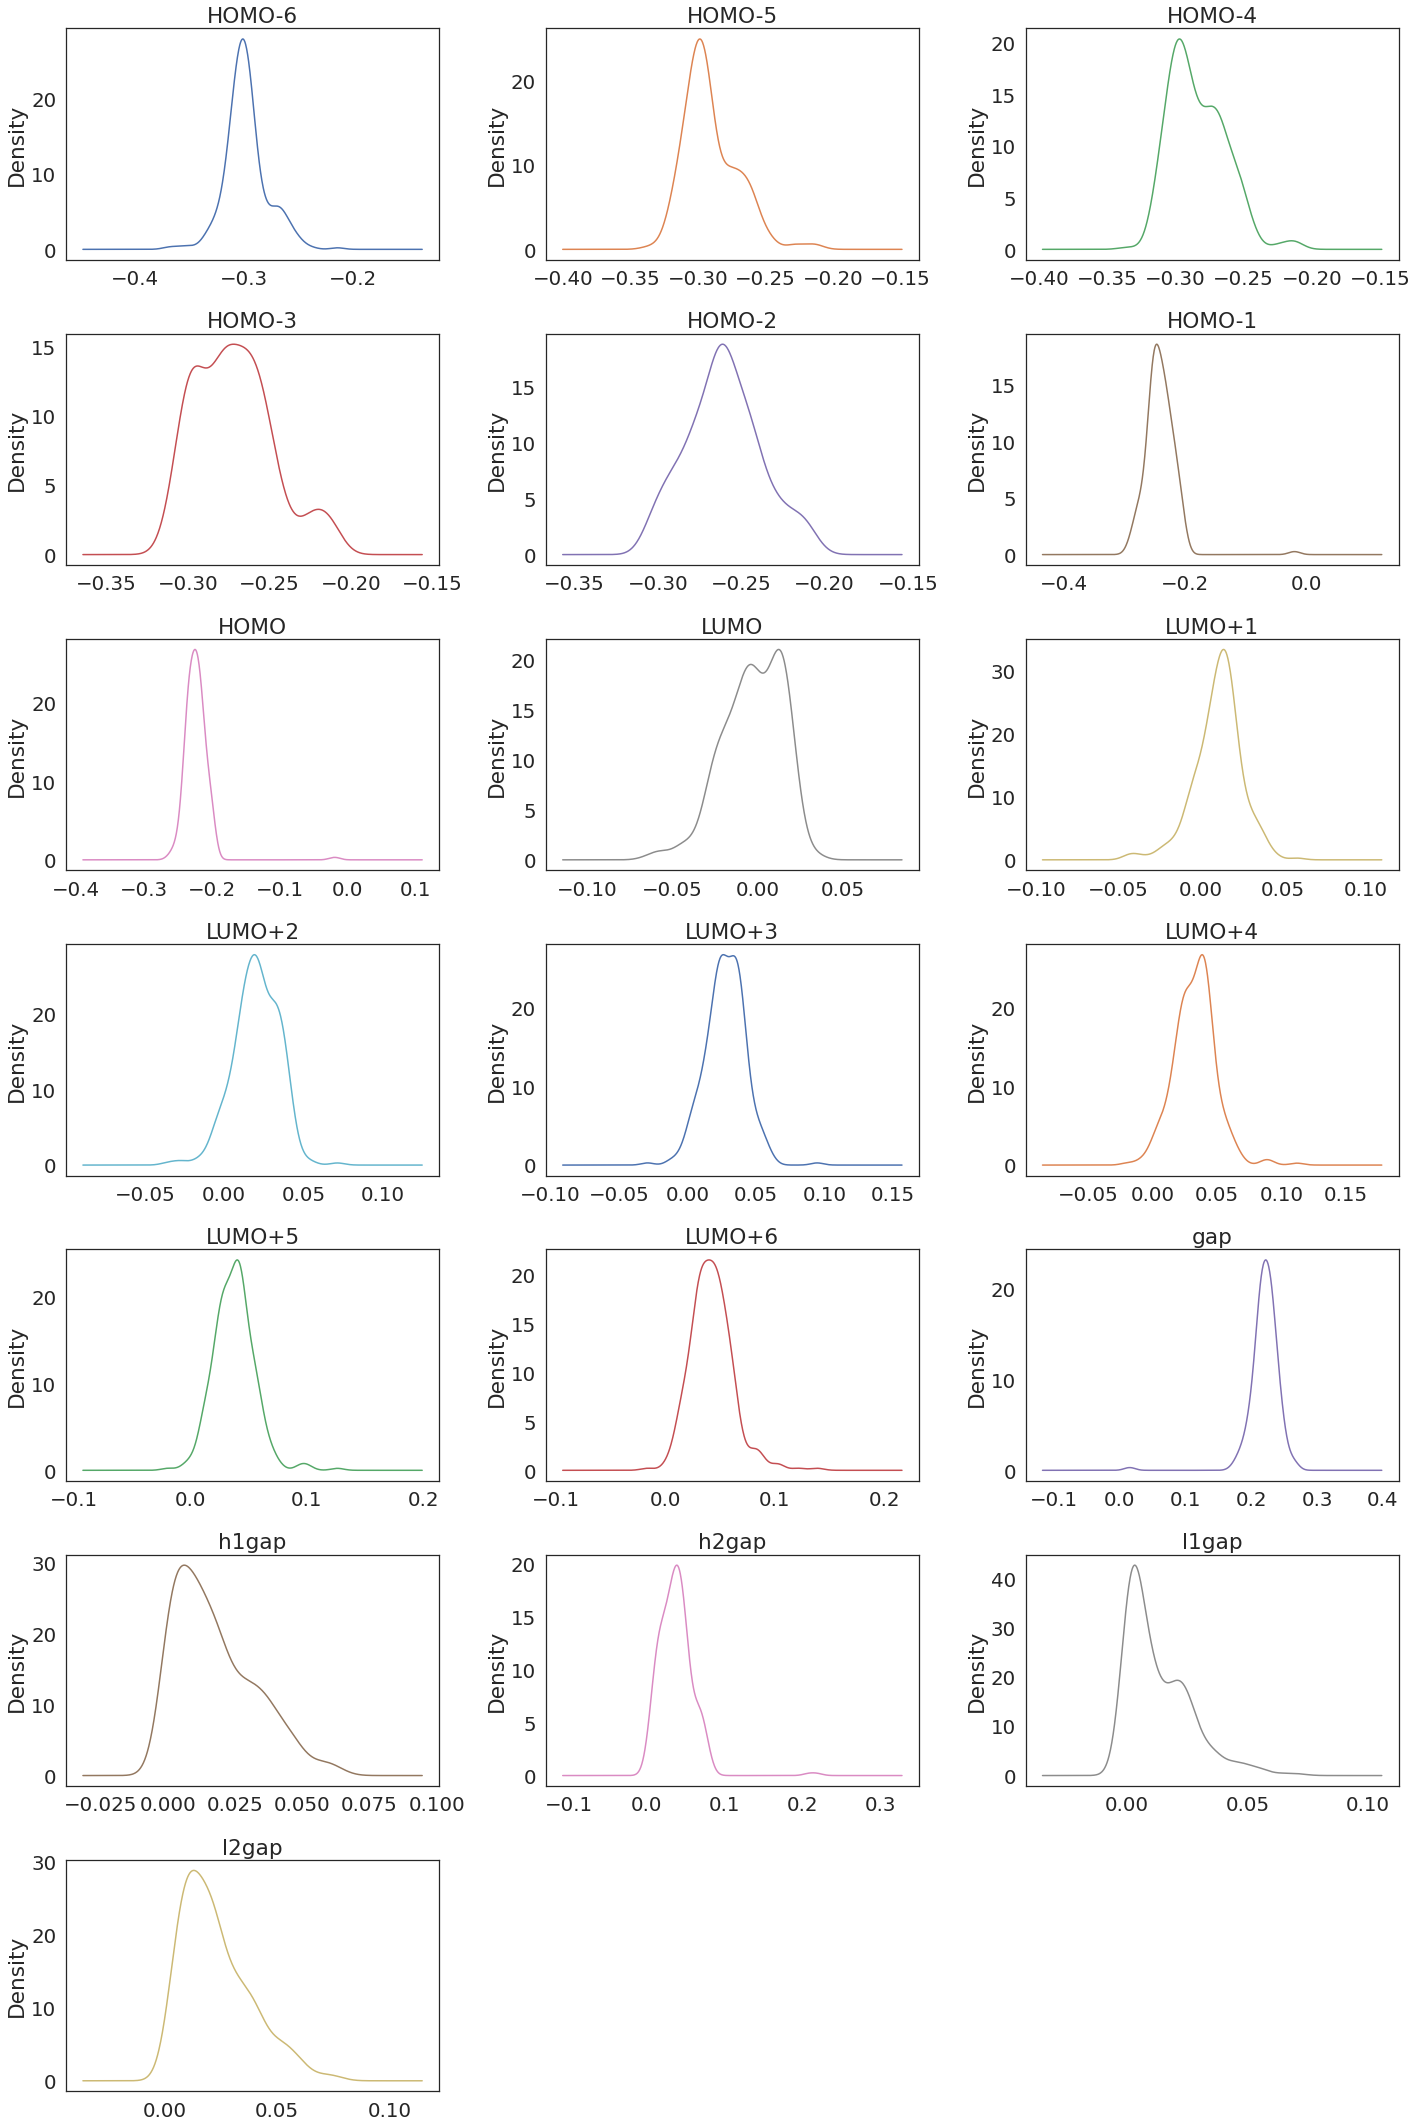

In [30]:
#②Kernel Density
import seaborn as sns

print(df5.shape)
sns.set(font_scale=1.8, style='white')
df5.iloc[:,:19].plot(kind='density', subplots=True, layout=(7,3), legend=False,
                    sharex=False, figsize=(20,30), title=df5.iloc[:,:19].columns.tolist());

plt.tight_layout() # 
plt.show()

(321, 41)


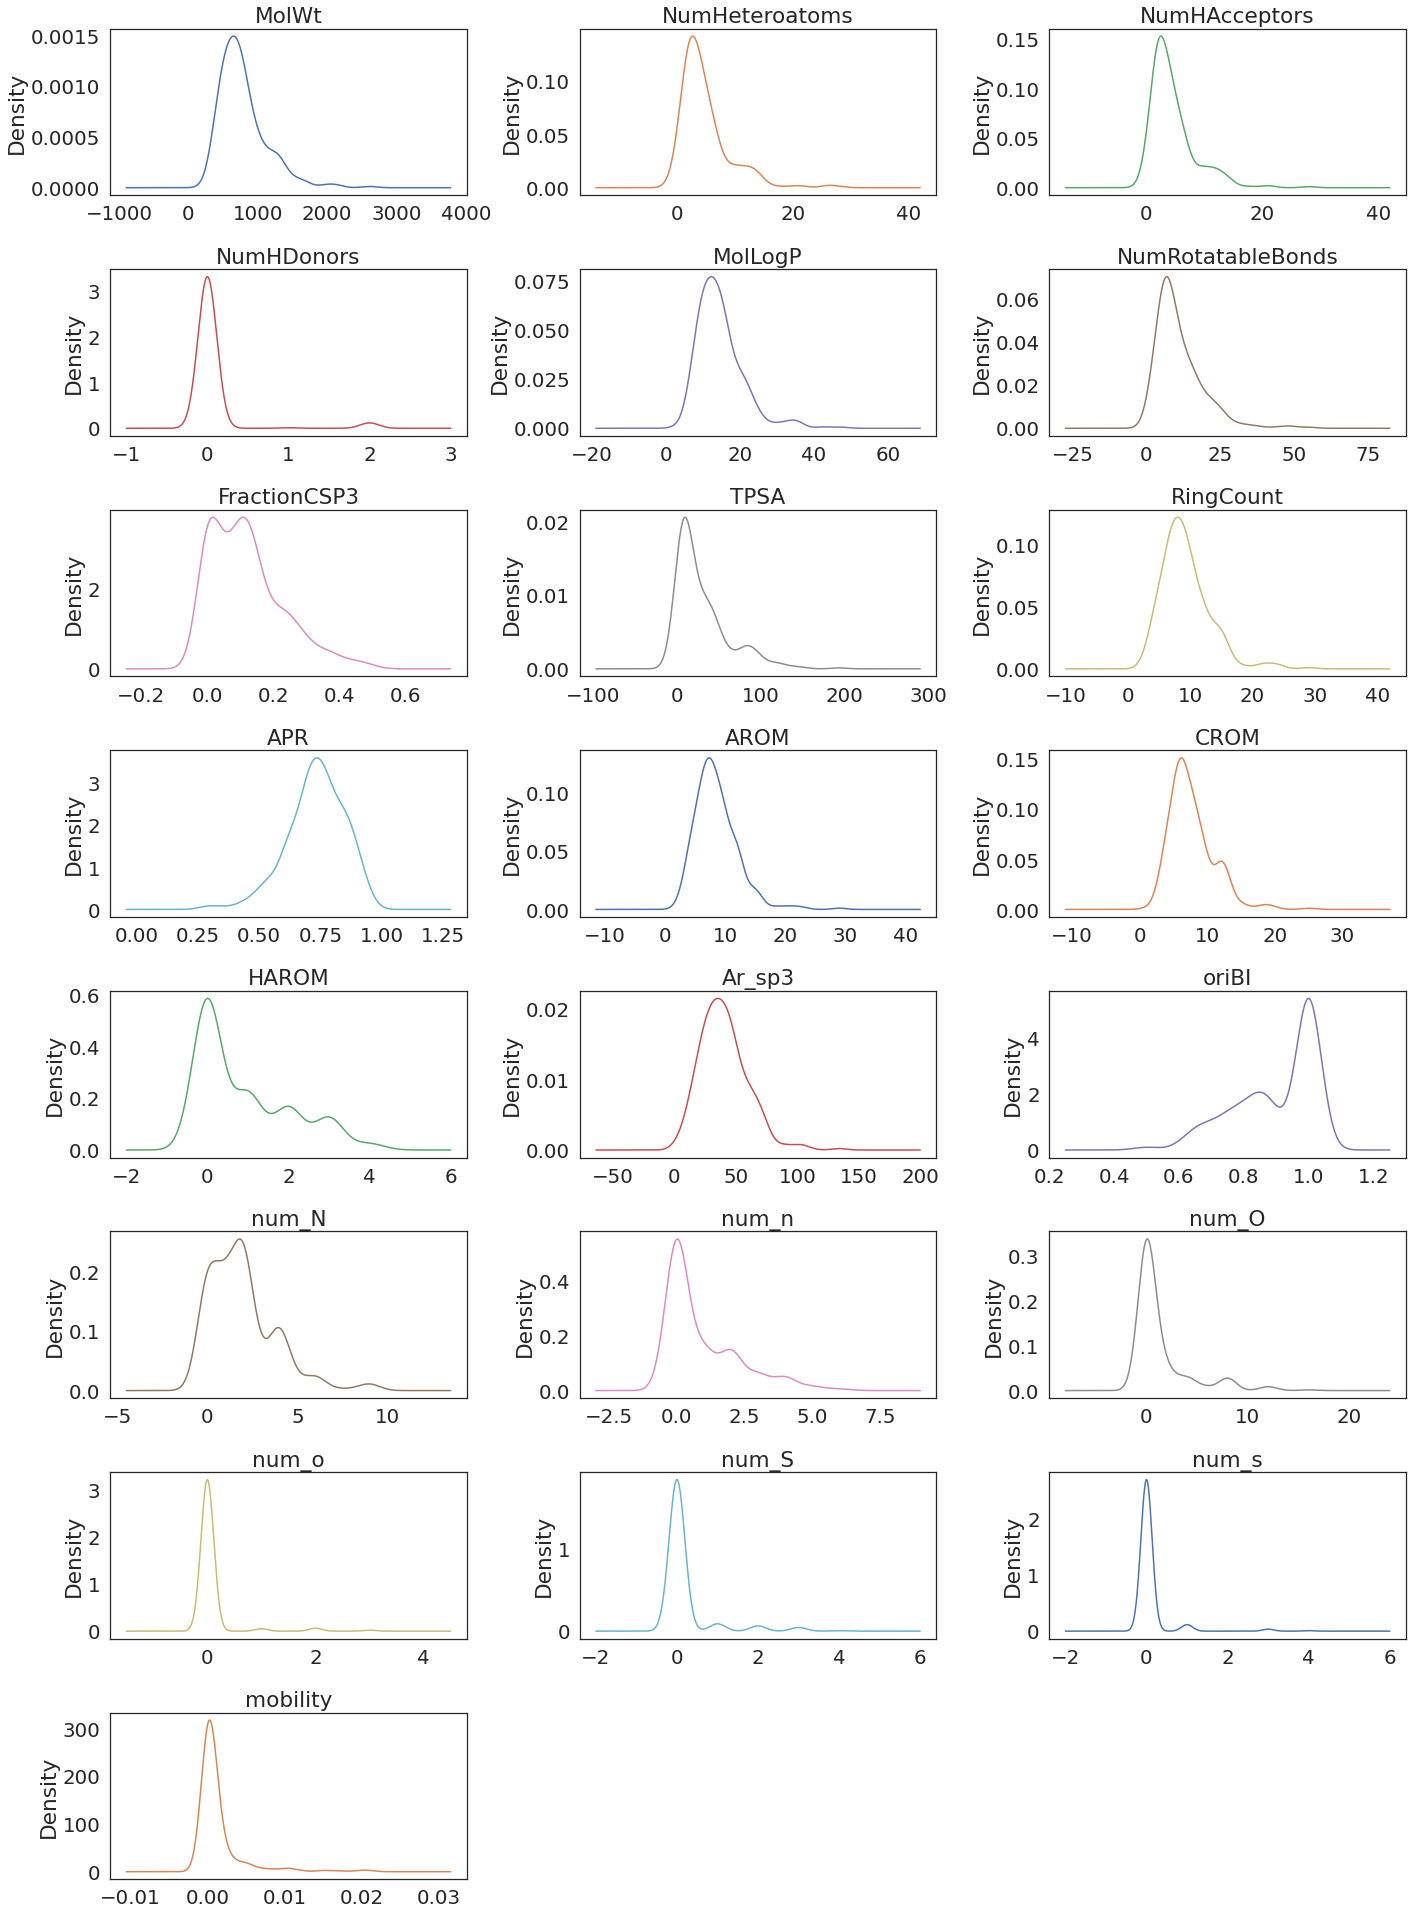

In [31]:
#②
import seaborn as sns

print(df5.shape)
sns.set(font_scale=1.8, style='white')
df5.iloc[:,19:].plot(kind='density', subplots=True, layout=(9,3), legend=False,
                    sharex=False, figsize=(20,30), title=df5.iloc[:,19:].columns.tolist());

plt.tight_layout() # 
plt.show()

/home/keijin/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


<Figure size 648x648 with 0 Axes>

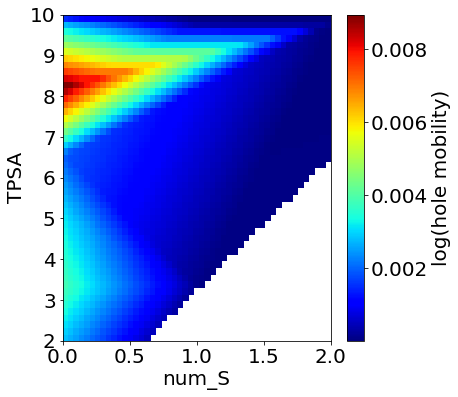

In [6]:
# ④ Heatmap
#### Importance #####
import scipy 
from scipy import interpolate

# Structure
z3=pd.DataFrame(df4,columns=['MolWt','NumHeteroatoms','NumHAcceptors','NumHDonors','MolLogP','NumRotatableBonds','FractionCSP3','TPSA',
                             'RingCount', 'APR', 'AROM', 'CROM', 'HAROM', 'oriBI', 'Ar_sp3', 'num_N', 'num_n', 'num_O', 'num_o', 'num_S', 'num_s'])

fps1 = [ AllChem.GetMorganFingerprintAsBitVect(mol,radius=2,nBits=1024) for mol in mols]    # ,useFeatures=True
fps2 = [ list(map(int,list(fps))) for fps in fps1]
fps=pd.DataFrame(fps2)
z3= pd.concat([z3,fps], axis=1)         

ya=pd.concat([z3,dfmob],axis=1)



#data make
#No1='num_S'
#No2='NumRotatableBonds'

No1='num_S'
No2='TPSA'
#No2=204

''''''
ya=pd.DataFrame(ya,columns=[No1,No2,'mobility'])
ya.to_csv('naisounew.csv')

#
ave=ya.groupby([No1,No2],as_index=False).mean()
ave.to_csv('ave.csv')

#naiso and toukousen plot
na =np.genfromtxt('ave.csv',delimiter=',')

#naiso and toukousen plot
x=na[:,1]
y=na[:,2]
z=na[:,3]
y=y[1:]
z=z[1:]
x=x[1:]
cartcoord = list(zip(x, y)) 
X = np.linspace(min(x), 2) 
Y = np.linspace(2, 10) 
X, Y = np.meshgrid(X, Y)  

#naiso
interp = scipy.interpolate.LinearNDInterpolator(cartcoord, z) 
Z = interp(X, Y) 


# plot
plt.subplots_adjust(wspace=0.4)


# plot true Z
plt.rcParams['font.size']=20
plt.figure(figsize=(6,6))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
im = plt.pcolormesh(X,Y,Z,cmap="jet")
plt.colorbar(im).set_label('log(hole mobility)',fontsize=20)
plt.xlabel(No1,fontsize=20)
plt.ylabel(No2,fontsize=20)
plt.show()

321
(321, 69)
test R2 :  0.7636732219346694
train R2 :  0.8854820221714619
test RMSE:  0.5555598128861438
train RMSE:  0.40740932993728995
Average score: 0.5641955743517535
##########################


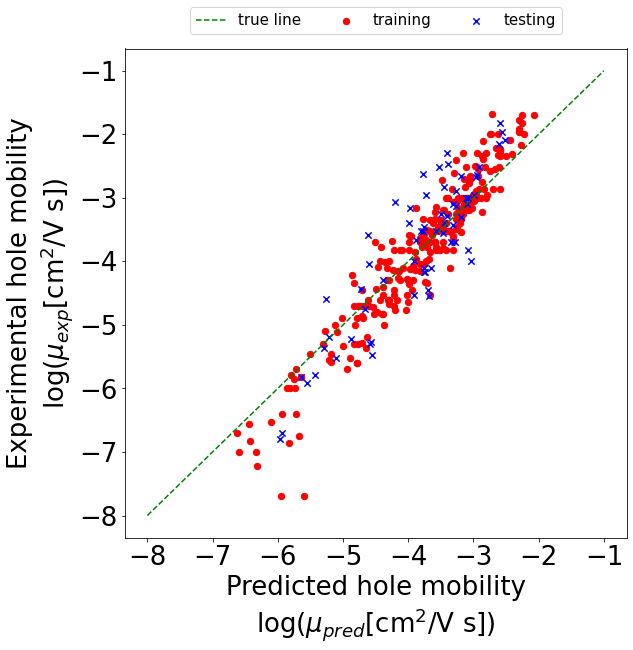

In [7]:
# ⑤ Random Forest　
# only structure


#
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem, Descriptors
from mordred import descriptors, Calculator
import numpy as np
import pandas as pd 
from pandas import DataFrame 
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
import math
import  _pickle as cPickle
import gzip, numpy, copy, math
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, rdmolops
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem import rdMolDescriptors
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from rdkit.Avalon import pyAvalonTools
from pandas import DataFrame as df
import time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold




#sdf

# 
new_z3=pd.DataFrame(df4,columns=['HOMO-6','HOMO-5','HOMO-4','HOMO-3','HOMO-2','HOMO-1','HOMO','LUMO','LUMO+1','LUMO+2','LUMO+3','LUMO+4','LUMO+5','LUMO+6','gap','h1gap', 'h2gap', 'l1gap', 'l2gap',
    'MolWt','NumHeteroatoms','NumHAcceptors','NumHDonors','MolLogP','NumRotatableBonds','FractionCSP3','TPSA',
                             'RingCount', 'APR', 'AROM', 'CROM', 'HAROM', 'oriBI', 'Ar_sp3', 'num_N', 'num_n', 'num_O', 'num_o', 'num_S', 'num_s'])


#Smiles

mols = Chem.SDMolSupplier('../datasets/Hole_mobility_onlyTOF300.sdf')
#FCFP
fps1 = [ AllChem.GetMorganFingerprintAsBitVect(mol,radius=2,nBits=1024) for mol in mols]    # ,useFeatures=True
fps2 = [ list(map(int,list(fps))) for fps in fps1]
fps=pd.DataFrame(fps2)
# 
new_ECFP_2_1024_099=fps.iloc[:,[943, 869, 86, 825, 502, 947, 982, 817, 921, 685, 88, 664, 853, 848, 770, 688, 925, 9, 752, 4, 69, 877, 217, 702, 92, 65, 871, 617, 810, 629, 514, 957, 942, 954, 889, 803, 797, 753, 899, 787, 554, 82, 566, 965, 708, 991, 856, 828, 396, 498, 648, 941, 833, 248, 639, 724, 850, 872, 998, 911, 432, 305, 795, 857, 832, 41, 646, 765, 665, 622,0, 1, 3, 5, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 31, 32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 87, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 102, 103, 104, 105, 106, 107, 108, 110, 111, 113, 114, 116, 117, 118, 119, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 153, 155, 156, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 197, 198, 200, 201, 202, 203, 204, 206, 208, 209, 211, 212, 214, 215, 216, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 242, 245, 246, 247, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 263, 264, 265, 267, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 284, 287, 288, 289, 290, 292, 293, 294, 297, 299, 300, 301, 302, 303, 304, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 344, 345, 347, 348, 349, 350, 351, 352, 355, 356, 358, 360, 361, 362, 364, 365, 366, 367, 368, 369, 370, 371, 373, 374, 377, 378, 379, 380, 381, 382, 383, 384, 385, 388, 389, 392, 393, 394, 395, 397, 398, 400, 401, 403, 404, 405, 406, 407, 408, 409, 410, 412, 413, 414, 415, 417, 418, 420, 421, 422, 423, 424, 427, 428, 429, 430, 431, 434, 435, 436, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 465, 466, 467, 470, 474, 475, 476, 477, 478, 479, 481, 482, 483, 484, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 499, 500, 501, 503, 504, 506, 507, 508, 510, 511, 512, 513, 515, 517, 518, 519, 520, 521, 524, 526, 527, 529, 530, 531, 532, 533, 534, 536, 537, 538, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 555, 556, 558, 559, 560, 561, 562, 563, 567, 568, 569, 570, 571, 572, 574, 575, 576, 577, 579, 580, 581, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 594, 595, 598, 601, 602, 603, 604, 605, 606, 608, 609, 610, 613, 615, 618, 620, 621, 623, 624, 625, 626, 628, 630, 631, 632, 633, 634, 635, 636, 637, 638, 640, 641, 642, 643, 644, 645, 647, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 666, 667, 668, 669, 670, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 689, 690, 691, 692, 694, 695, 698, 699, 700, 701, 703, 704, 705, 706, 707, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 749, 755, 756, 757, 758, 759, 760, 761, 762, 763, 766, 767, 768, 769, 771, 772, 773, 774, 775, 776, 778, 779, 780, 781, 782, 784, 785, 786, 788, 789, 790, 791, 792, 793, 794, 796, 798, 799, 801, 802, 804, 805, 806, 807, 808, 809, 811, 812, 814, 815, 816, 818, 819, 820, 822, 824, 826, 827, 829, 831, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 849, 851, 852, 854, 855, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 870, 873, 874, 875, 876, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 890, 891, 892, 893, 895, 896, 897, 898, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 912, 914, 915, 916, 917, 918, 919, 920, 922, 923, 924, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 944, 945, 946, 948, 949, 950, 951, 952, 953, 955, 956, 958, 959, 960, 961, 962, 963, 964, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 983, 984, 985, 986, 987, 988, 989, 990, 992, 993, 994, 995, 996, 997, 999, 1000, 1002, 1003, 1004, 1006, 1007, 1008, 1009, 1012, 1013, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022]
    ]
fps=new_ECFP_2_1024_099




#X
z3_old= pd.concat([new_z3,fps], axis=1)         #


z3 = z3_old[[898, 'num_N', 875, 139, 896, 'num_o', 215, 698, 212, 561, 956, 829, 891, 63, 736, 675, 950, 'NumHDonors', 19, 64, 785, 799, 33, 1013, 136, 338, 929, 'HAROM', 257, 549, 566, 261, 364, 73, 940, 114, 119, 15, 45, 271, 'num_n', 233, 801, 1009, 393, 'CROM', 723, 315, 'FractionCSP3', 452, 305, 655, 'NumHeteroatoms', 746, 'NumHAcceptors', 'NumRotatableBonds', 'oriBI', 378, 1017, 204, 'RingCount', 'Ar_sp3', 'MolWt', 'APR', 'MolLogP', 790, 'TPSA', 'AROM', 'num_S'
            ]]
X = np.array(z3, dtype = np.float32)

print(len(fps))
print(z3.shape)



#ｙ
sdf = [ mol for mol in Chem.SDMolSupplier('../datasets/Hole_mobility_onlyTOF300.sdf')]
def getResponse( mols, prop= "mobility" ):
    y = []
    for mol in mols:
        act = mol.GetProp( prop )
        y.append( act )
    return y
y = getResponse(sdf)
y = np.array(y, dtype = np.float32)
y = np.log10(y)
y=np.reshape(y,(-1))  
y = pd.DataFrame(y)


#Random Forest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


#    

rs=591598
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=rs)


                
#
regressor= RandomForestRegressor(random_state=2201, max_depth=14, max_features=38, n_estimators=18)
regressor.fit(X_train, y_train.values.ravel())
score = regressor.score(X_test, y_test)



# Cross Varidataion
skf = KFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(regressor, X, y, cv=skf, n_jobs=8)
'''
# 各分割におけるスコア
#print('Cross-Validation scores: {}'.format(scores))
# スコアの平均値
print('Average score: {}'.format(np.mean(scores)))

                
print('Average score: {}'.format(np.mean(scores)))
print('n_estimators:', estimator, 'max_features:',feature ,'max_depth:',depth,  'random_state:', rs)
'''
                    
#
y_predictions = regressor.predict(X_test)
#
pred_train = regressor.predict(X_train)

print('test R2 : ', regressor.score(X_test, y_test))  
print('train R2 : ', regressor.score(X_train, y_train))
print('test RMSE: ', np.sqrt(mean_squared_error(y_test, y_predictions)))  
print('train RMSE: ', np.sqrt(mean_squared_error(y_train, pred_train)))
print('Average score: {}'.format(np.mean(scores)))
print('##########################')                    
                    




#Figure
plt.rcParams['figure.figsize'] = (9.0, 9.0)
plt.plot([-8, -1], [-8, -1], 'g--', label='true line')   # 
plt.scatter(pred_train, y_train, c='r', s=40, label='training')
plt.scatter(y_predictions, y_test, c='b', s=40, label='testing', marker='x')
plt.legend(bbox_to_anchor=(1.05, 1), title='Legend', fontsize=16)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3,  fontsize=15);    # legend on the graph


plt.ylabel('Experimental hole mobility\nlog(${µ_{exp}}$' +r'$\mathrm{[{cm^2}/V}$ s])', fontsize=26)    # Latex $\mathrm{}
plt.xlabel('Predicted hole mobility\nlog(${µ_{pred}}$'+r'$\mathrm{[{cm^2}/V}$ s])', fontsize=26)
plt.xticks([-8,-7,-6,-5,-4,-3,-2,-1],fontsize=26)
plt.yticks([-8,-7,-6,-5,-4,-3,-2,-1],fontsize=26)
plt.show()



# new_ECFP_2_1024    > 0.002   only structure

321
(321, 85)
Average score: 0.533491467895342
test R2 :  0.5912239972834574
train R2 :  0.887503062385577
test RMSE:  0.7306628931453111
train RMSE:  0.4037982990855667
Average score: 0.533491467895342
##########################


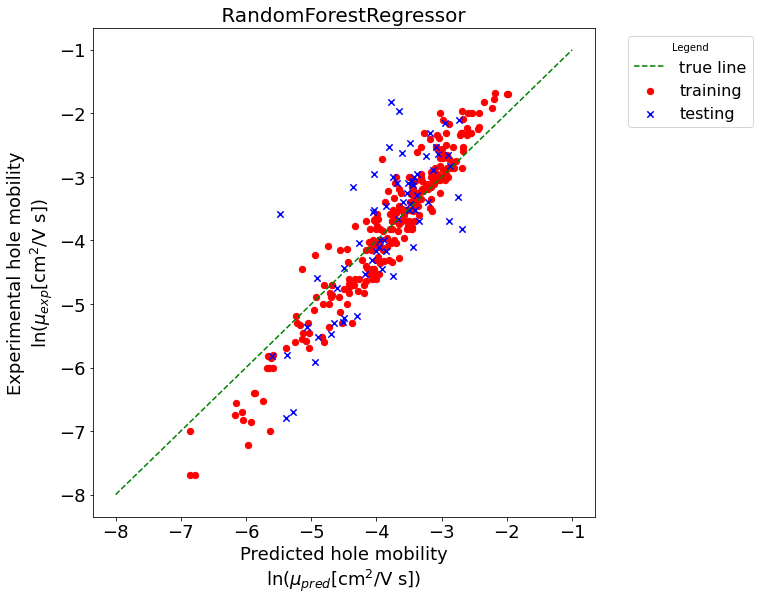

In [4]:
# ⑥ Random Forest
# HOMO LUMO



#sdf

# 
new_z3=pd.DataFrame(df4,columns=['HOMO-6','HOMO-5','HOMO-4','HOMO-3','HOMO-2','HOMO-1','HOMO','LUMO','LUMO+1','LUMO+2','LUMO+3','LUMO+4','LUMO+5','LUMO+6','gap','h1gap', 'h2gap', 'l1gap', 'l2gap',
    'MolWt','NumHeteroatoms','NumHAcceptors','NumHDonors','MolLogP','NumRotatableBonds','FractionCSP3','TPSA',
                             'RingCount', 'APR', 'AROM', 'CROM', 'HAROM', 'oriBI', 'Ar_sp3', 'num_N', 'num_n', 'num_O', 'num_o', 'num_S', 'num_s'])


#Smiles

mols = Chem.SDMolSupplier('../datasets/Hole_mobility_onlyTOF300.sdf')
#FCFP
fps1 = [ AllChem.GetMorganFingerprintAsBitVect(mol,radius=2,nBits=1024) for mol in mols]    # ,useFeatures=True
fps2 = [ list(map(int,list(fps))) for fps in fps1]
fps=pd.DataFrame(fps2)
#
new_ECFP_2_1024_099=fps.iloc[:,[943, 869, 86, 825, 502, 947, 982, 817, 921, 685, 88, 664, 853, 848, 770, 688, 925, 9, 752, 4, 69, 877, 217, 702, 92, 65, 871, 617, 810, 629, 514, 957, 942, 954, 889, 803, 797, 753, 899, 787, 554, 82, 566, 965, 708, 991, 856, 828, 396, 498, 648, 941, 833, 248, 639, 724, 850, 872, 998, 911, 432, 305, 795, 857, 832, 41, 646, 765, 665, 622,0, 1, 3, 5, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 31, 32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 87, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 102, 103, 104, 105, 106, 107, 108, 110, 111, 113, 114, 116, 117, 118, 119, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 153, 155, 156, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 197, 198, 200, 201, 202, 203, 204, 206, 208, 209, 211, 212, 214, 215, 216, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 242, 245, 246, 247, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 263, 264, 265, 267, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 284, 287, 288, 289, 290, 292, 293, 294, 297, 299, 300, 301, 302, 303, 304, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 344, 345, 347, 348, 349, 350, 351, 352, 355, 356, 358, 360, 361, 362, 364, 365, 366, 367, 368, 369, 370, 371, 373, 374, 377, 378, 379, 380, 381, 382, 383, 384, 385, 388, 389, 392, 393, 394, 395, 397, 398, 400, 401, 403, 404, 405, 406, 407, 408, 409, 410, 412, 413, 414, 415, 417, 418, 420, 421, 422, 423, 424, 427, 428, 429, 430, 431, 434, 435, 436, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 465, 466, 467, 470, 474, 475, 476, 477, 478, 479, 481, 482, 483, 484, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 499, 500, 501, 503, 504, 506, 507, 508, 510, 511, 512, 513, 515, 517, 518, 519, 520, 521, 524, 526, 527, 529, 530, 531, 532, 533, 534, 536, 537, 538, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 555, 556, 558, 559, 560, 561, 562, 563, 567, 568, 569, 570, 571, 572, 574, 575, 576, 577, 579, 580, 581, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 594, 595, 598, 601, 602, 603, 604, 605, 606, 608, 609, 610, 613, 615, 618, 620, 621, 623, 624, 625, 626, 628, 630, 631, 632, 633, 634, 635, 636, 637, 638, 640, 641, 642, 643, 644, 645, 647, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 666, 667, 668, 669, 670, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 689, 690, 691, 692, 694, 695, 698, 699, 700, 701, 703, 704, 705, 706, 707, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 749, 755, 756, 757, 758, 759, 760, 761, 762, 763, 766, 767, 768, 769, 771, 772, 773, 774, 775, 776, 778, 779, 780, 781, 782, 784, 785, 786, 788, 789, 790, 791, 792, 793, 794, 796, 798, 799, 801, 802, 804, 805, 806, 807, 808, 809, 811, 812, 814, 815, 816, 818, 819, 820, 822, 824, 826, 827, 829, 831, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 849, 851, 852, 854, 855, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 870, 873, 874, 875, 876, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 890, 891, 892, 893, 895, 896, 897, 898, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 912, 914, 915, 916, 917, 918, 919, 920, 922, 923, 924, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 944, 945, 946, 948, 949, 950, 951, 952, 953, 955, 956, 958, 959, 960, 961, 962, 963, 964, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 983, 984, 985, 986, 987, 988, 989, 990, 992, 993, 994, 995, 996, 997, 999, 1000, 1002, 1003, 1004, 1006, 1007, 1008, 1009, 1012, 1013, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022]
    ]
fps=new_ECFP_2_1024_099




#X
z3_old= pd.concat([new_z3,fps], axis=1)         #　

z3 = z3_old[[175, 650, 958, 'HAROM', 969, 227, 269, 36, 261, 891, 361, 288, 929, 15, 785, 781, 1017, 181, 64, 723, 831, 58, 294, 801, 917, 835, 63, 'num_O', 'num_n', 790, 598, 'num_N', 392, 233, 512, 305, 49, 655, 641, 1020, 960, 257, 114, 271, 19, 378, 'CROM', 393, 561, 452, 'oriBI', 746, 'RingCount', 'FractionCSP3', 315, 'l1gap', 'HOMO', 'HOMO-4', 'Ar_sp3', 'h2gap', 'HOMO-3', 'NumHeteroatoms', 'gap', 'LUMO+3', 'NumHAcceptors', 'HOMO-5', 204, 'HOMO-2', 'MolLogP', 'LUMO+1', 'LUMO+4', 'APR', 'AROM', 'LUMO+5', 'LUMO', 'MolWt', 'LUMO+2', 'l2gap', 'NumRotatableBonds', 'TPSA', 'h1gap', 'HOMO-1', 'LUMO+6', 'num_S', 'HOMO-6']]

X = np.array(z3, dtype = np.float32)

print(len(fps))
print(z3.shape)



#ｙ
sdf = [ mol for mol in Chem.SDMolSupplier('../datasets/Hole_mobility_onlyTOF300.sdf')]
def getResponse( mols, prop= "mobility" ):
    y = []
    for mol in mols:
        act = mol.GetProp( prop )
        y.append( act )
    return y
y = getResponse(sdf)
y = np.array(y, dtype = np.float32)
y = np.log10(y)
y=np.reshape(y,(-1))  
y = pd.DataFrame(y)


#ランダムフォレスト
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


#   

rs = 486346

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=rs)


                
#RF
regressor= RandomForestRegressor(random_state=751, max_depth=13, max_features=18, n_estimators=21)
regressor.fit(X_train, y_train.values.ravel())
score = regressor.score(X_test, y_test)



# Cross Validation
skf = KFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(regressor, X, y, cv=skf, n_jobs=8)
                
print('Average score: {}'.format(np.mean(scores)))
#print('n_estimators:', estimator, 'max_features:',feature ,'max_depth:',depth,  'random_state:', rs)

                    
#
y_predictions = regressor.predict(X_test)
#
pred_train = regressor.predict(X_train)

print('test R2 : ', regressor.score(X_test, y_test))   #
print('train R2 : ', regressor.score(X_train, y_train))
print('test RMSE: ', np.sqrt(mean_squared_error(y_test, y_predictions)))  #
print('train RMSE: ', np.sqrt(mean_squared_error(y_train, pred_train)))
print('Average score: {}'.format(np.mean(scores)))
print('##########################')                    
                    




#
plt.rcParams['figure.figsize'] = (9.0, 9.0)
plt.title(' RandomForestRegressor ',fontsize=20)
plt.plot([-8, -1], [-8, -1], 'g--', label='true line')   # 
plt.scatter(pred_train, y_train, c='r', s=40, label='training')
plt.scatter(y_predictions, y_test, c='b', s=40, label='testing', marker='x')
plt.legend(bbox_to_anchor=(1.05, 1), title='Legend', fontsize=16)
plt.ylabel('Experimental hole mobility\nln(${µ_{exp}}$' +r'$\mathrm{[{cm^2}/V}$ s])', fontsize=18)    # Latex $\mathrm{}
plt.xlabel('Predicted hole mobility\nln(${µ_{pred}}$'+r'$\mathrm{[{cm^2}/V}$ s])', fontsize=18)
plt.xticks([-8,-7,-6,-5,-4,-3,-2,-1],fontsize=18)
plt.yticks([-8,-7,-6,-5,-4,-3,-2,-1],fontsize=18)
plt.show()



# new_ECFP_2_1024    > 0.002   HOMO LUMO 

Your desire number0.03
RandomForestRegressor(max_depth=14, max_features=38, n_estimators=18,
                      random_state=2201)
test R2 :  0.7636732219346694
train R2 :  0.8854820221714619
test RMSE:  0.5555598128861438
train RMSE:  0.40740932993728995
len(names) =  69
lenghs =  10
        column              importance
0       num_S               0.1018260830295272
1       TPSA                0.06924434465237833
2       Ar_sp3              0.06763473692502986
3       NumRotatableBonds   0.06306720055317373
4       APR                 0.051519560815864056
5       MolWt               0.045078698258441074
6       FractionCSP3        0.041629987174617876
7       MolLogP             0.03757654978147286
8       RingCount           0.03243549575736649
9       790                 0.03093641257017989


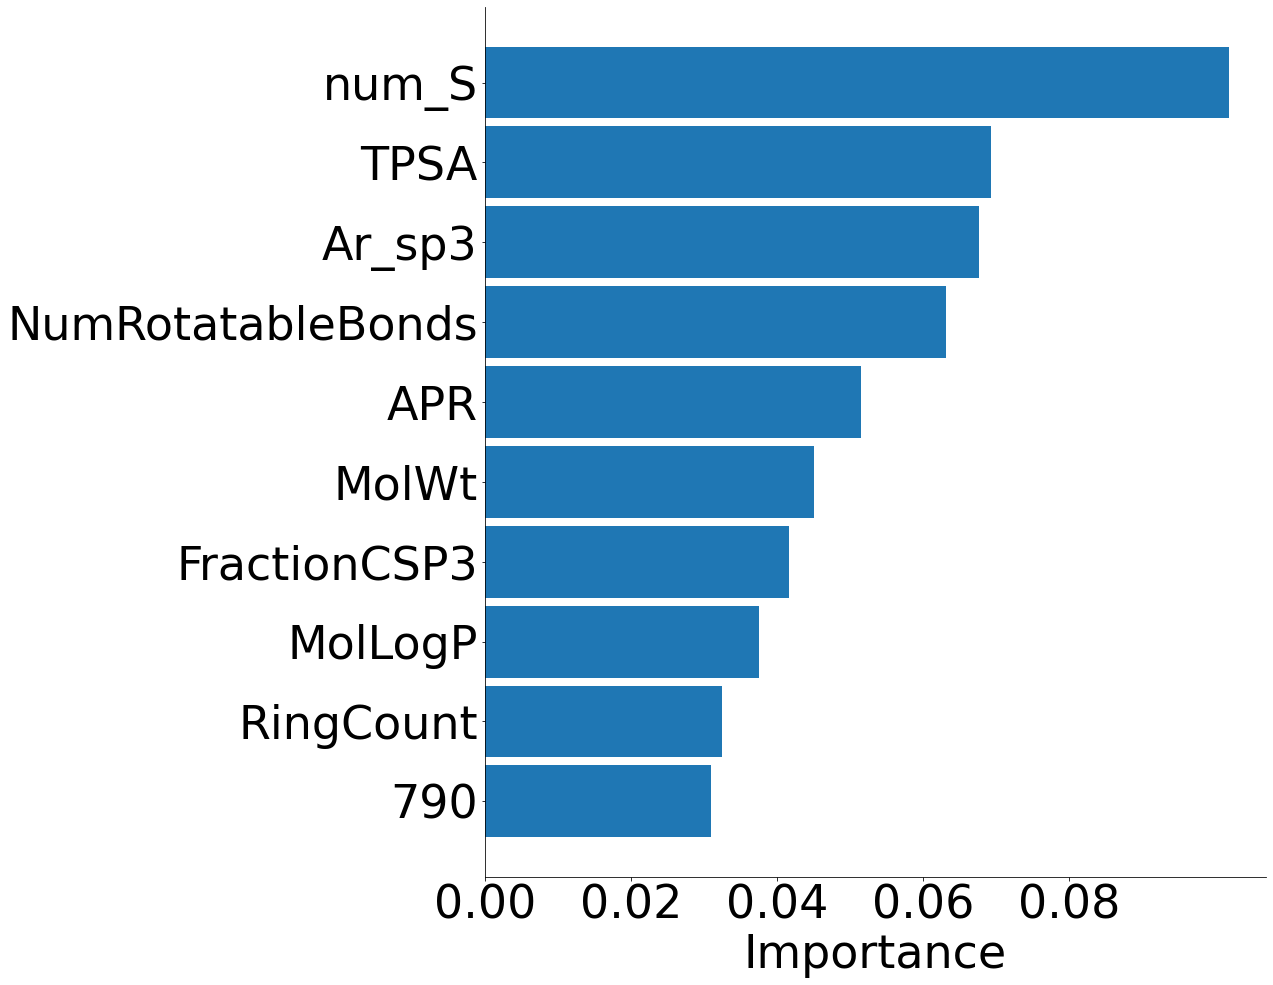

In [10]:
# ⑦　ECFP4

desire = float(input('Your desire number'))
print(regressor)
print('test R2 : ', regressor.score(X_test, y_test))   #
print('train R2 : ', regressor.score(X_train, y_train))
print('test RMSE: ', np.sqrt(mean_squared_error(y_test, y_predictions)))  #
print('train RMSE: ', np.sqrt(mean_squared_error(y_train, pred_train)))

importance = regressor.feature_importances_.tolist()
names = list(z3)
print('len(names) = ', len(names))

zipped = zip (names, importance)
zipped = list(zipped)
res = sorted(zipped, key = lambda x:x[1], reverse =True)
names , importance = zip(*sorted(zipped, key= lambda x:x[1], reverse =True))


b=importance
c=np.array(b,dtype = np.float64)
count=np.sum(c>desire)
names=np.array(names[:count])
x = np.arange(z3.shape[1])
x =np.array(x[:count])
importance =c[c>desire]
print('lenghs = ', len(importance))


fmt = '{:<8}{:<20}{}'
print(fmt.format('', 'column', 'importance'))
for i, (name, coef) in enumerate(zip(names, importance)):
    print(fmt.format(i, name, coef)) 
    
importance, names = zip(*sorted(zip(importance, names), reverse=False))
plt.figure(figsize=(14,16));
fig = plt.barh(x, importance, 0.9, align='center')
plt.xlabel('Importance',fontsize=46)
#plt.ylabel(fontsize=28)
plt.yticks(x,names,fontsize=46)
plt.xticks([0.00, 0.02, 0.04, 0.06, 0.08], fontsize=46)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

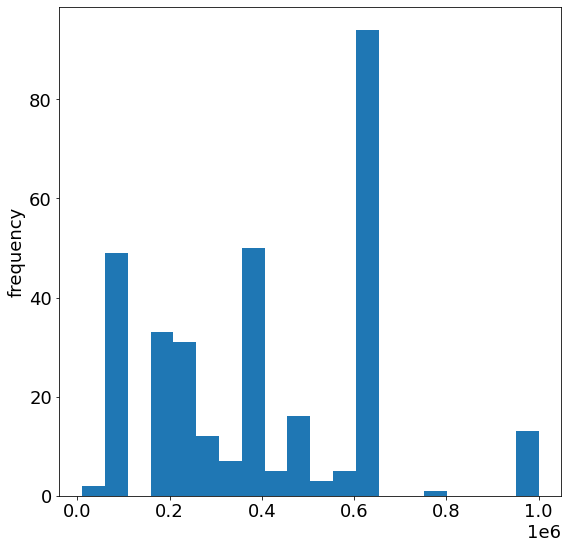

max 1000000.0
min 10000.0


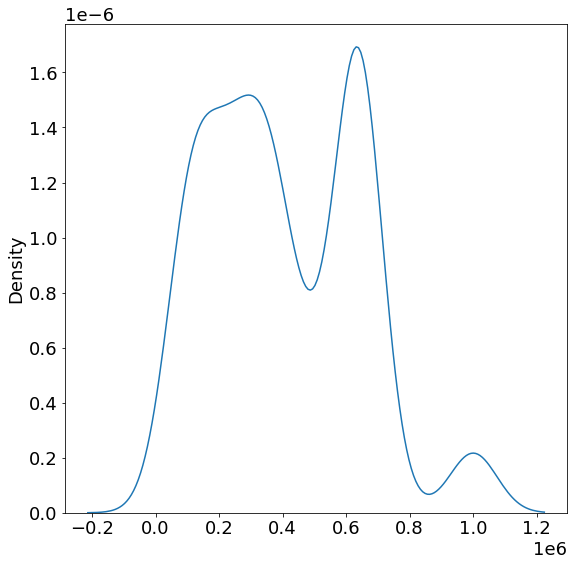

In [25]:
# ⑧

import matplotlib.pyplot as plt
import pandas

dfz = PandasTools.LoadSDF('./original300/onlyTOF.sdf', molColName='ROMol',embedProps=True) 
denkai =list(dfz['e'])
den_list = []

# 
denkai_replace = [s.replace('E', 'e') for s in denkai]

# 
for i in range(len(denkai_replace)):
    den_list.append(float(denkai_replace[i]))



variable_number=0
number_of_bins=20


plt.rcParams['font.size']=18
plt.hist(den_list, bins=number_of_bins)
#plt.xlabel(check)
#plt.xticks([1e6,1e5,1e4])
#plt.xscale('log')
plt.ylabel('frequency')
plt.show()




print('max',max(den_list))
print('min',min(den_list))

# 
sns.kdeplot(den_list)
#plt.xscale('log')
plt.show()

/home/keijin/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


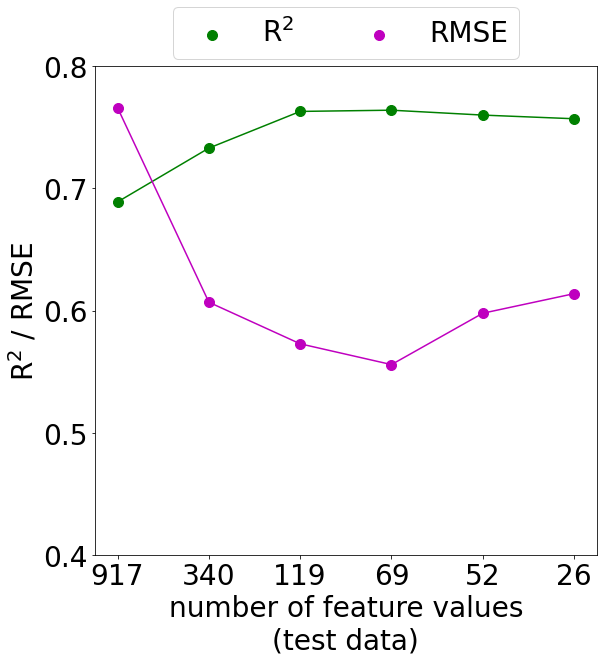

<Figure size 864x576 with 0 Axes>

In [2]:
from rdkit import Chem
from mordred import descriptors, Calculator
import numpy as np
import pandas as pd 
from pandas import DataFrame 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
import math
import  _pickle as cPickle
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from pandas import DataFrame as df
import time


#図作成
plt.rcParams['figure.figsize'] = (9.0, 9.0)
plt.rcParams['font.size']=28
plt.scatter(['917', '340', '119', '69', '52', '26'], [0.689, 0.733, 0.763, 0.764, 0.760, 0.757], c='g', s=100, label='R$^\mathrm{2}$')
plt.scatter(['917', '340', '119', '69', '52', '26'], [0.766, 0.607, 0.573, 0.556, 0.598, 0.614], c='m', s=100, label='RMSE')

# line
plt.plot(['917', '340', '119', '69', '52', '26'], [0.689, 0.733, 0.763, 0.764, 0.760, 0.757], c='g')
plt.plot(['917', '340', '119', '69', '52', '26'], [0.766, 0.607, 0.573, 0.556, 0.598, 0.614], c='m')

ax=plt.subplot()


plt.legend(loc=4, frameon=True);    # legend in the graph
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2);    # legend on the graph

plt.xlabel('number of feature values\n(test data)')
plt.ylabel('R$^\mathrm{2}$ / RMSE')

#plt.xticks([-9,-8,-7,-6,-5,-4,-3,-2,-1])
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8])
fig = plt.figure(figsize=(12, 8))
#plt.savefig("img.jpg", bbox_inches='tight')
#ax.grid()
plt.show()
#fig.savefig("img.png")